translation successful?
gravity center of first plane should equal [0,0,0]:  [-7.4014868308343765e-17, -7.1054273576010019e-15, -2.9605947323337506e-16]
after first rotation
first normal:  [3.341841182549098e-16, 11.918987030035318, 1.3058822286022631e-15]
after second rotation
first normal:  [1.3699971855500128e-16, 11.91898703003532, -1.3409841524003463e-15]
transformation successful?
gravity center of first plane should equal [0,0,0]:  [-7.4014868308343765e-17, -7.1054273576010019e-15, -2.9605947323337506e-16]
first normal; x and z coordinate should equal zero:  [1.3699971855500128e-16, 11.91898703003532, -1.3409841524003463e-15]
angle between n1 and y-axis should equal zero:  0.0


<IPython.core.display.Javascript object>


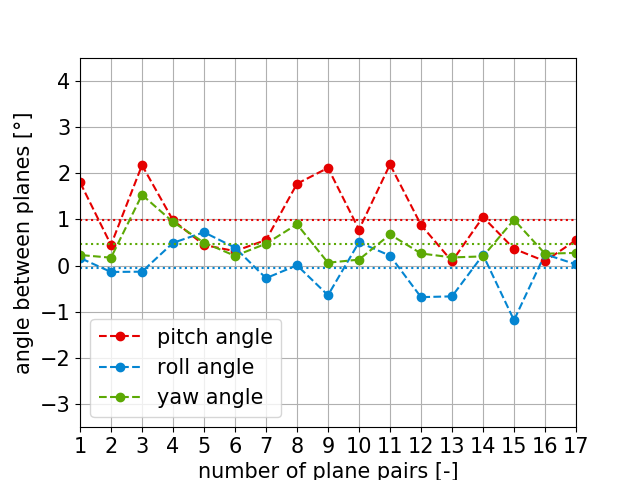

L:\Programme\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


[ -2.65379875e-14   6.86034616e+00   1.35406930e+01   2.00423382e+01
   2.60669187e+01   3.26067203e+01   3.83908624e+01   4.46117325e+01
   5.09848391e+01   5.69676109e+01   6.25177892e+01   6.86465130e+01
   7.41879200e+01   7.95567725e+01   8.48932145e+01   9.00762001e+01
   9.49735818e+01   1.00000000e+02]


<IPython.core.display.Javascript object>


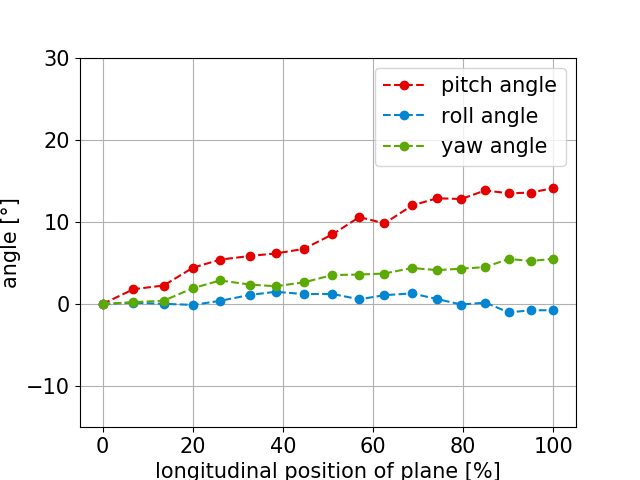

<IPython.core.display.Javascript object>


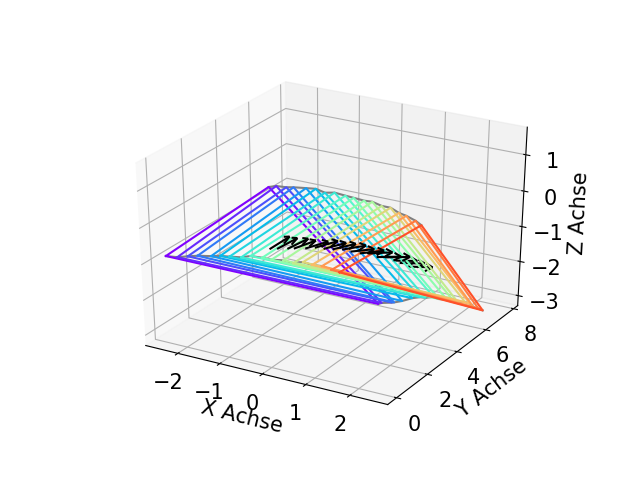

In [6]:
%matplotlib notebook
from math import sqrt, acos, pi, atan2
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import matplotlib
from pyquaternion import Quaternion
import csv

# import point coordinates
files = {}
files['left'] = "horizontal/all points horizontal left.fcsv"
files['middle'] = "horizontal/all points horizontal middle.fcsv"
files['right'] = "horizontal/all points horizontal right.fcsv"

points = {}

# write all points to respective list in dictionary
for file in files.keys():
    with open(files[file], "r") as fin:
        tmp = []
        for line in fin:
            if ( len(line.split(",")) == 1 ):
                continue
            if line.split(",")[1] == "x":
                continue
                
            tmp.append([float(point)/1000.0 for point in line.split(",")[1:4]])
        tmp = np.array(tmp)
        points[file] = tmp
        
# calculate normal vector of plane spanned by three points
def normalVector(a, b, c):
    bMinusA = []
    cMinusA = []
    
    for i in range(3):
        bMinusA.append(b[i] - a[i])
        cMinusA.append(c[i] - a[i])

    return [bMinusA[1]*cMinusA[2] - bMinusA[2]*cMinusA[1],
           bMinusA[2]*cMinusA[0] - bMinusA[0]*cMinusA[2],
           bMinusA[0]*cMinusA[1] - bMinusA[1]*cMinusA[0]]

# scale vector to unit vector (length = 1)
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

# calculate center of gravity of the respective plane
def gravityCenter(a, b, c):
    return [(1/3)*(a[i] + b[i] + c[i]) for i in range(3)]

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))    
   
### TRANSLATION -----------------------------------------------------
# calculate offset for translating origin to gravity center of the first plane
offset = gravityCenter(points["left"][0,:], points["middle"][0,:], points["right"][0,:])

# apply offset to all points
for i in range(18):
    points["left"][i] -= offset
    points["middle"][i] -= offset
    points["right"][i] -= offset
    
### Test: Translation successful? -----------------------------------
print("translation successful?")
gravityCenter0 = gravityCenter(points["left"][0,:], points["middle"][0,:], points["right"][0,:])
print("gravity center of first plane should equal [0,0,0]: ", gravityCenter0)
    
### ROTATION --------------------------------------------------------
# calculate new y-axis (= normal of first plane)
xzNormal = np.asarray([0., 1., 0.])
firstNormal = normalVector(points["left"][0], points["middle"][0], points["right"][0])  
firstNormal = unit_vector(firstNormal)

# rotate coordinate system so that the first normal equals the y-axis
rotAxis = np.cross(firstNormal, xzNormal) #calculate rotation axis
#calculate rotation angle
cos_theta = np.dot(firstNormal, xzNormal);
rotAngle = acos(cos_theta);
#create quaternion from angle axis representation
q = Quaternion(axis=rotAxis, radians=rotAngle)
q = q.normalised

# apply rotation to all points
for i in range(18):
    points["left"][i] = q.rotate(points["left"][i])
    points["middle"][i] = q.rotate(points["middle"][i])
    points["right"][i] = q.rotate(points["right"][i])
    
print("after first rotation")
n1 = normalVector(points["left"][0], points["middle"][0], points["right"][0])                            
print("first normal: ",n1) 

# calculate rotation so that x-axis is parallel to straight between left/right points of first plane
leftToRight = points["right"][0] - points["left"][0]
leftToRightAngle = atan2(leftToRight[2], leftToRight[0])

# apply rotation to all points
qLR = Quaternion(axis=(0.0, 1.0, 0.0), radians=leftToRightAngle)
for i in range(18):
    points["left"][i] = qLR.rotate(points["left"][i])
    points["middle"][i] = qLR.rotate(points["middle"][i])
    points["right"][i] = qLR.rotate(points["right"][i]) 
    
print("after second rotation")
n1 = normalVector(points["left"][0], points["middle"][0], points["right"][0])                            
print("first normal: ",n1) 

### TEST: coordinate transformation successful?-------------------------------------------------------
print("transformation successful?")
n1 = normalVector(points["left"][0], points["middle"][0], points["right"][0])      
print("gravity center of first plane should equal [0,0,0]: ", gravityCenter0)
print("first normal; x and z coordinate should equal zero: ",n1) 
print("angle between n1 and y-axis should equal zero: ", angle_between(n1, [0,1,0])*(180/pi))

### CALCULATE PITCH, ROLL, YAW ANGLES-----------------------------------------------------
angles = {}
angles["roll"] = []
angles["pitch"] = []
angles["yaw"] = []

normals = []

# relative: Angle between Planes ---------------------------------------------------------
matplotlib.rcParams.update({'font.size': 15})

for i in range(17): # n = 17
    n1 = normalVector(points["left"][i], points["middle"][i], points["right"][i])
    normals.append(n1)
    n2 = normalVector(points["left"][i+1], points["middle"][i+1], points["right"][i+1])
    lToR = points["right"][i] - points["left"][i]
    lToR2 = points["right"][i+1] - points["left"][i+1]
    roll1 = atan2(lToR[2], lToR[0])
    roll2 = atan2(lToR2[2], lToR2[0])
    roll = roll2 - roll1;
    pitch = angle_between([0, n1[1], n1[2]], [0, n2[1], n2[2]])
    yaw = angle_between([n1[0], n1[1], 0], [n2[0], n2[1], 0])
    angles["roll"].append(roll*(180/pi))
    angles["pitch"].append(pitch*(180/pi))
    angles["yaw"].append(yaw*(180/pi))

plt.figure(1)
plt.plot(np.append(np.roll(angles["pitch"],1),angles["pitch"][16]), label="pitch angle", ls="--", marker = "o", color = 'xkcd:red')
plt.axhline(np.average(angles["pitch"]), color = 'xkcd:red', linestyle = ':')
plt.plot(np.append(np.roll(angles["roll"],1),angles["roll"][16]), label="roll angle", ls="--", marker = "o", color = 'xkcd:cerulean')
plt.axhline(np.average(angles["roll"]), color = 'xkcd:cerulean', linestyle = ':')
plt.plot(np.append(np.roll(angles["yaw"],1),angles["yaw"][16]), label="yaw angle", ls="--", marker = "o", color='xkcd:leaf green')
plt.axhline(np.average(angles["yaw"]), color='xkcd:leaf green', linestyle = ':')
plt.legend()
plt.grid()
plt.xlabel('number of plane pairs [-]')
plt.ylabel('angle between planes [°]')
dim=np.arange(1,18,1)
plt.xticks(dim)
axes = plt.subplot(111)
axes.set_xlim(1,17,1)
axes.set_ylim([-3.5,4.5])
plt.show()

# write results of relative values to txt file
f = open( 'aAvStd_horizontal.txt', 'w' )
#f.write('avWidth' + ' , ' + repr(avWidth) + '\n' + 'stdWidth' + ' , ' + repr(stdWidth) + '\n' + 'percStdWidth' + ' , ' + repr(percStdWidth) + '\n'
 #       'avLength' + ' , ' + repr(avLength) + '\n' + 'stdLength' + ' , ' + repr(stdLength) + '\n' + 'percStdLength' + ' , ' + repr(percStdLength) + '\n'
  #'avHeight' + ' , ' + repr(avHeight) + '\n' + 'stdHeight' + ' , ' + repr(stdHeight) + '\n' + 'percStdHeight' + ' , ' + repr(percStdHeight) + '\n'  )
f.write('average pitch' + ' , ' + repr(np.average(angles["pitch"]))+ ' , '  + 'std pitch' + ' , ' + repr(np.std(angles["pitch"]))+ '\n'
       'average roll' + ' , ' + repr(np.average(angles["roll"]))+ ' , '  + 'std roll' + ' , ' + repr(np.std(angles["roll"]))+ '\n'
       'average yaw' + ' , ' + repr(np.average(angles["yaw"]))+ ' , '  + 'std yaw' + ' , ' + repr(np.std(angles["yaw"]))+ '\n')
f.close()

# absolute: cumulated angles -------------------------------------------------------------

angles["roll"] = []
angles["pitch"] = []
angles["yaw"] = []

for i in range(18): # one data point more, as no differences are calculated
    n1 = normalVector(points["left"][0], points["middle"][0], points["right"][0])
    n2 = normalVector(points["left"][i], points["middle"][i], points["right"][i])
    lToR = points["right"][i] - points["left"][i]
    roll = atan2(lToR[2], lToR[0])
    pitch = angle_between([0, n2[1], n2[2]], [0, n1[1], n1[2]])
    yaw = angle_between([n1[0], n1[1], 0], [n2[0], n2[1], 0])
    angles["roll"].append(roll*(180/pi))
    angles["pitch"].append(pitch*(180/pi))
    angles["yaw"].append(yaw*(180/pi))
    #print("roll {}, pitch: {}, yaw: {}".format(roll*(180/pi), pitch*(180/pi), yaw*(180/pi)))
                                    
# scale x-axis values to position in ray
#length = points["middle"][17,1]
#print("max distance of planes: ", length)
LocOnY = (points["middle"][:,1]/points["middle"][17,1])*100
print(LocOnY)
    
plt.figure(3)
plt.plot(LocOnY, angles["pitch"], label="pitch angle", ls="--", marker = "o", color = 'xkcd:red')
plt.plot(LocOnY, angles["roll"], label="roll angle", ls="--", marker = "o", color = 'xkcd:cerulean')
plt.plot(LocOnY, angles["yaw"], label="yaw angle", ls="--", marker = "o", color = 'xkcd:leaf green')
plt.legend()
plt.xlabel('longitudinal position of plane [%]')
#plt.xlabel('$\frac{\text{Plane Position}}{\text{Total Distance}}$ [%]')
plt.ylabel('angle [°]')
plt.grid()
#dim=np.arange(1,19,1)
#plt.xticks(dim)
axes2 = plt.subplot(111)
#axes2.set_xlim(1,18,1)
axes2.set_ylim([-15,30])
plt.show()

# plot points and respective normal vectors located in gravity center ------------------------------------
fig = plt.figure(4)
ax = fig.add_subplot(111, projection='3d')
colors=iter(cm.rainbow(np.linspace(0,1,20)))

for side in ("left", "middle", "right"):
    ax.plot([points[side][i][0] for i in range(18)],
        [points[side][i][1] for i in range(18)],
        [points[side][i][2] for i in range(18)], label=side, color="grey")

for i, c in zip(range(18), colors):
    ax.plot([points["left"][i][0], points["middle"][i][0], points["right"][i][0], points["left"][i][0]],
            [points["left"][i][1], points["middle"][i][1], points["right"][i][1], points["left"][i][1]],
            [points["left"][i][2], points["middle"][i][2], points["right"][i][2], points["left"][i][2]], color=c)

# plot normals with base located in gravity center
for i, n in enumerate(normals):
    gc = gravityCenter(points["left"][i,:], points["middle"][i,:], points["right"][i,:])
    ax.quiver(gc[0], gc[1], gc[2], gc[0]+n[0], gc[1]+n[1], gc[2]+n[2], length = 0.1, color = "black")

ax.set_xlabel("X Achse")
ax.set_ylabel("Y Achse")
ax.set_zlabel("Z Achse")
plt.show()
